# RNN vs DNN

- sin波+ノイズのデータから正しいsin波が予測できるかを，RNNとDNNで比較します．
- データ100点を入力し，次の1点を予測するタスクです．

In [38]:
# GPUメモリ初期化
from keras import backend as K
K.clear_session()

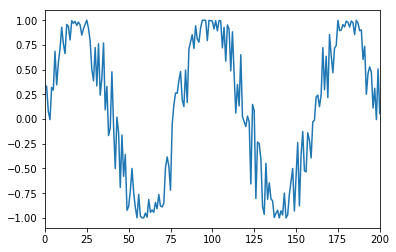

In [39]:
# sin波の生成

import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(0)

# 乱数の係数
random_factor = 0.5

# サイクルあたりのステップ数
steps_per_cycle = 80

# 生成するサイクル数
number_of_cycles = 50

t = np.arange(steps_per_cycle * number_of_cycles + 1)
sin_t = np.array([math.sin(x * (2 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor) for x in t])

plt.figure()
plt.plot(sin_t)
plt.xlim(0,200)
plt.show()


In [40]:
# データセット分割用
def train_test_split(data, test_size=0.1, n_prev = 100):  
    test_len = int(len(data)*test_size)
    train_len = len(data) - test_len
    
    X_train = np.empty((train_len-1,n_prev))
    X_test = np.empty((test_len,n_prev))
    Y_train = np.empty(train_len-1)
    Y_test = np.empty(test_len)
    
    for i in range(train_len-1):
        X_train[i] = data[i:i+n_prev]
        Y_train[i] = data[i+n_prev]

    for i in range(test_len-n_prev):
        X_test[i] = data[i+train_len:i+train_len+n_prev]        
        Y_test[i] = data[i+train_len+n_prev]
        
    return (X_train, Y_train), (X_test, Y_test)

In [41]:
# X_trainには入力の100系列分，Y_trainには101番目のデータが入ります．

length_of_sequences = 100
(X_train, Y_train), (X_test, Y_test) = train_test_split(sin_t, n_prev =length_of_sequences)

## RNN

In [42]:
print(X_train.shape)
print(X_test.shape)

(3600, 100)
(400, 100)


In [43]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM

X_train = X_train.reshape(-1, length_of_sequences, 1)
X_test = X_test.reshape(-1, length_of_sequences, 1)

in_out_neurons = 1
hidden_neurons = 100

model = Sequential()  
model.add(LSTM(hidden_neurons, batch_input_shape=(None, length_of_sequences, in_out_neurons)))  
model.add(Dense(in_out_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mean_squared_error", optimizer="rmsprop")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.fit(X_train, Y_train, batch_size=128, epochs=5, validation_data=(X_test, Y_test)) 

Train on 3600 samples, validate on 400 samples
Epoch 1/5
3600/3600 [==============================] - 5s - loss: 0.1237 - val_loss: nan
Epoch 2/5
3600/3600 [==============================] - 4s - loss: 0.0506 - val_loss: nan
Epoch 3/5
3600/3600 [==============================] - 4s - loss: 0.0503 - val_loss: nan
Epoch 4/5
3600/3600 [==============================] - 4s - loss: 0.0482 - val_loss: nan
Epoch 5/5
3600/3600 [==============================] - 4s - loss: 0.0481 - val_loss: nan


## DNN

In [45]:
model2 = Sequential()  
model2.add(Dense(hidden_neurons, batch_input_shape=(None, length_of_sequences,)))  
model2.add(Dense(in_out_neurons))  
model2.add(Activation("linear"))  
model2.compile(loss="mean_squared_error", optimizer="rmsprop")
model2.summary()

X_train = X_train.reshape(-1,100)
X_test = X_test.reshape(-1,100)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 10,201
Trainable params: 10,201
Non-trainable params: 0
_________________________________________________________________


In [46]:
model2.fit(X_train, Y_train, batch_size=128, epochs=5, validation_data=(X_test, Y_test)) 

Train on 3600 samples, validate on 400 samples
Epoch 1/5
3600/3600 [==============================] - 0s - loss: 0.3251 - val_loss: nan
Epoch 2/5
3600/3600 [==============================] - 0s - loss: 0.2008 - val_loss: nan
Epoch 3/5
3600/3600 [==============================] - 0s - loss: 0.1789 - val_loss: nan
Epoch 4/5
3600/3600 [==============================] - 0s - loss: 0.1720 - val_loss: nan
Epoch 5/5
3600/3600 [==============================] - 0s - loss: 0.1519 - val_loss: nan


## 比較

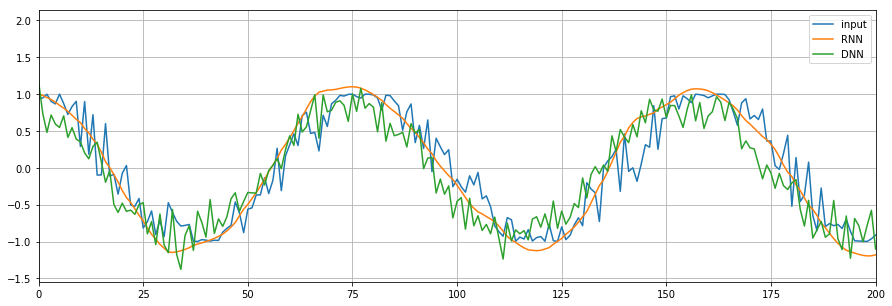

In [47]:
X_test = X_test.reshape(-1,100,1)
predicted = model.predict(X_test)

X_test = X_test.reshape(-1,100)
predicted2 = model2.predict(X_test) 

plt.figure(figsize=(15,5))
plt.plot(Y_test, label="input")
plt.plot(predicted, label="RNN")
plt.plot(predicted2, label="DNN")
plt.xlim(0,200)
plt.legend()
plt.grid()
plt.show()
